# 数据集



## 数据集下载

关于本项目的数据集保存在[Kaggle](https://www.kaggle.com/)的[huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)中，下面的单元格可以直接下载该数据集并返回其路径。

In [1]:
import os
import kagglehub

# 使用KaggleHub下载数据集
dataset_name = "huizecai/mushroom"
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/huizecai/mushroom/versions/3


## 计算各蘑菇种类的图片数量

由于tensorflow中会有中文路径异常问题，该数据集中的各种类的文件夹名以“classXX”来命名，并用label.txt来与其中文名进行映射。

In [2]:
dataset_path = path + '/archive/data'
label_path = path + '/archive/label.txt'

# 获取所有子目录（即蘑菇类别）
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
categories = {}
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            category_name = parts[0]
            category_id = parts[1]
            categories[category_id] = category_name

# 统计每种类别的图像数量
category_counts = {}
for category_id in categories.keys():
    if category_id in dir_names:  # 确保目录存在
        category_dir = os.path.join(dataset_path, category_id)
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        category_counts[categories[category_id]] = num_images

print("Category counts:", category_counts)

Category counts: {'羊肚菌': 170, '牛肝菌': 157, '鸡油菌': 163, '鸡枞菌': 166, '青头菌': 193, '奶浆菌': 194, '干巴菌': 167, '虎掌菌': 187, '白葱牛肝菌': 190, '老人头菌': 176, '猪肚菌': 122, '谷熟菌': 171, '白参菌': 179, '黑木耳': 182, '银耳': 160, '金耳': 178, '猴头菇': 183, '香菇': 179, '平菇': 165, '金针菇': 140, '口蘑': 173, '鹿茸菇': 175, '榆黄蘑': 177, '榛蘑': 176, '草菇': 166, '鸡腿菇': 161, '茶树菇': 177, '蟹味菇': 146, '白玉菇': 158, '红菇': 184, '杏鲍菇': 162, '松茸': 191, '姬松茸': 185, '松露': 157, '竹荪': 184, '虫草花': 194}


## 处理中文字体异常问题

在部分运行环境中，matplotlib可能会出现中文显示异常问题。此处将加载“SimHei”字体以解决该问题。

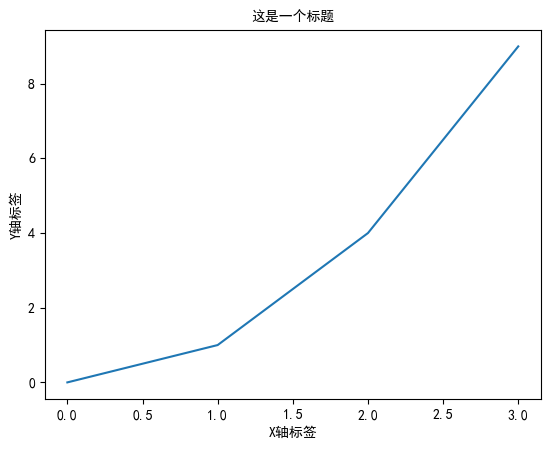

In [3]:
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, fontManager

# 下载并保存字体文件
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"
font_name = "SimHei.ttf"
if not os.path.exists(font_name):
    urllib.request.urlretrieve(font_url, font_name)

# 注册字体文件到matplotlib的字体管理器
fontManager.addfont(font_name)

# 设置字体属性
font_prop = FontProperties(fname=font_name)

# 确保matplotlib使用正确的字体族名称
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 示例绘图
plt.title('这是一个标题', fontproperties=font_prop)
plt.xlabel('X轴标签', fontproperties=font_prop)
plt.ylabel('Y轴标签', fontproperties=font_prop)
plt.plot([0, 1, 2, 3], [0, 1, 4, 9])
plt.show()

## 绘制各种类图片数量的柱状图

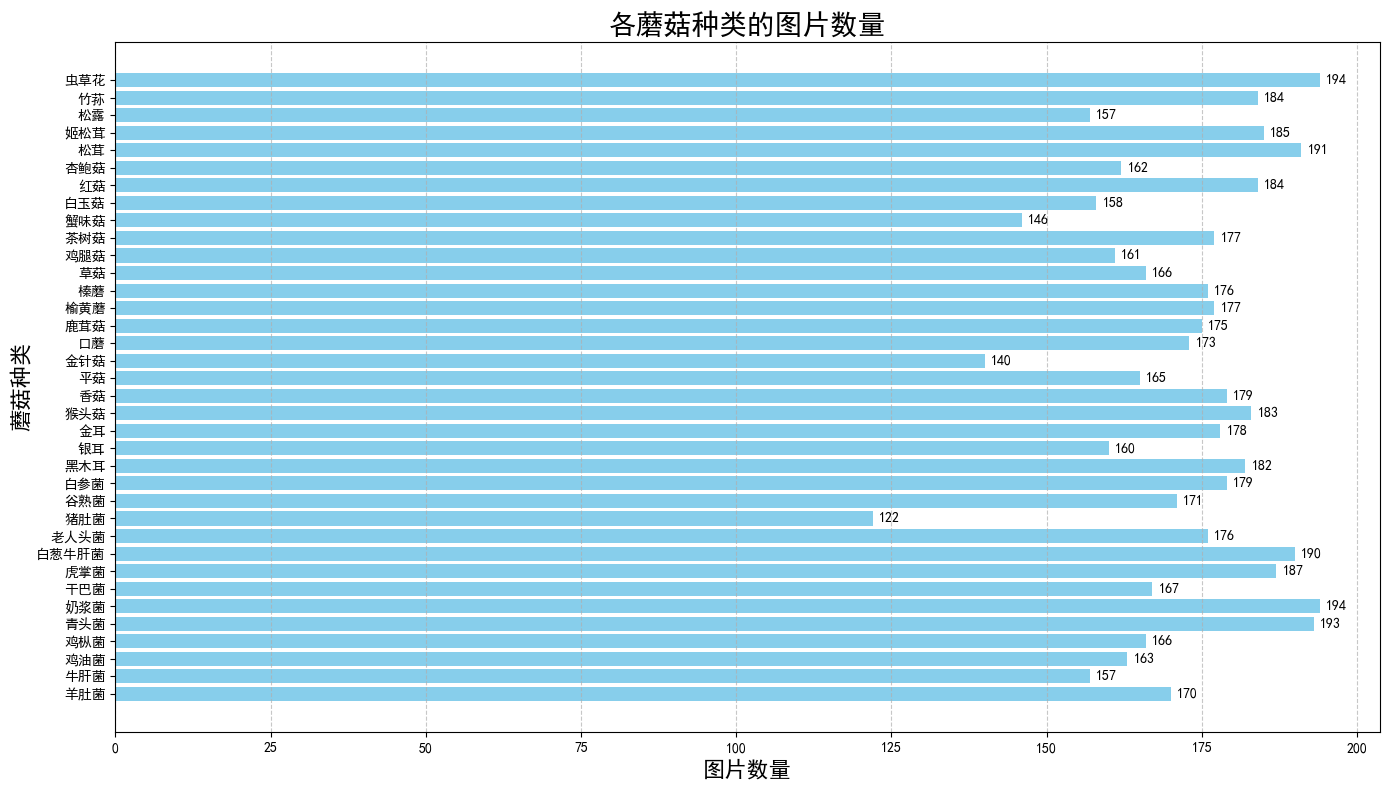

In [4]:
# 准备数据
categories_readable = list(category_counts.keys())
counts = list(category_counts.values())

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 绘制柱状图
bars = plt.barh(categories_readable, counts, color='skyblue')

# 添加数据标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, '%d' % int(width), va='center')

# 设置标题和标签
plt.title('各蘑菇种类的图片数量', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置网格
plt.grid(axis='x', linestyle='--', alpha=0.7)
# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 训练准备工作

## 加载图像数据集

使用 TensorFlow 的 [image_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en) 函数加载和准备图像数据集：


*   directory=dataset_path ：指定图像数据所在的路径。
*   image_size=(224, 224) ：指定每个图像的大小为224x224像素。
*   batch_size=32 ：指定每个批次包含32张图像。
*   validation_split=0.1 ：指定10%的数据作为验证集。
*   subset='both' ：指定同时返回训练集和验证集。
*   label_mode='categorical' ：指定标签模式为分类模式，返回one-hot编码的标签。
*   seed=21 ：设置随机种子以确保数据集的可重复性。



In [5]:
import tensorflow as tf

# 加载和准备图像数据集
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.1,
    subset='both',
    label_mode='categorical',
    seed=21
)

Found 6188 files belonging to 36 classes.
Using 5570 files for training.
Using 618 files for validation.


## 计算训练集和验证集的各种类图片分布

In [6]:
import numpy as np

# 获取类别名称
class_names = train_dataset.class_names

# 初始化字典用于存储每种类别的图像数量
train_category_counts = {name: 0 for name in categories.values()}
validation_category_counts = {name: 0 for name in categories.values()}

# 统计训练集中的图像数量
for images, labels in train_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        train_category_counts[categories[category_name]] += 1

# 统计验证集中的图像数量
for images, labels in validation_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        validation_category_counts[categories[category_name]] += 1


print("训练集类别图像数量统计:", train_category_counts)
print("验证集类别图像数量统计:", validation_category_counts)

训练集类别图像数量统计: {'羊肚菌': 149, '牛肝菌': 143, '鸡油菌': 141, '鸡枞菌': 146, '青头菌': 171, '奶浆菌': 175, '干巴菌': 144, '虎掌菌': 171, '白葱牛肝菌': 166, '老人头菌': 162, '猪肚菌': 110, '谷熟菌': 157, '白参菌': 163, '黑木耳': 153, '银耳': 149, '金耳': 162, '猴头菇': 163, '香菇': 159, '平菇': 146, '金针菇': 121, '口蘑': 160, '鹿茸菇': 162, '榆黄蘑': 160, '榛蘑': 162, '草菇': 149, '鸡腿菇': 144, '茶树菇': 160, '蟹味菇': 126, '白玉菇': 145, '红菇': 173, '杏鲍菇': 152, '松茸': 169, '姬松茸': 171, '松露': 140, '竹荪': 165, '虫草花': 181}
验证集类别图像数量统计: {'羊肚菌': 21, '牛肝菌': 14, '鸡油菌': 22, '鸡枞菌': 20, '青头菌': 22, '奶浆菌': 19, '干巴菌': 23, '虎掌菌': 16, '白葱牛肝菌': 24, '老人头菌': 14, '猪肚菌': 12, '谷熟菌': 14, '白参菌': 16, '黑木耳': 29, '银耳': 11, '金耳': 16, '猴头菇': 20, '香菇': 20, '平菇': 19, '金针菇': 19, '口蘑': 13, '鹿茸菇': 13, '榆黄蘑': 17, '榛蘑': 14, '草菇': 17, '鸡腿菇': 17, '茶树菇': 17, '蟹味菇': 20, '白玉菇': 13, '红菇': 11, '杏鲍菇': 10, '松茸': 22, '姬松茸': 14, '松露': 17, '竹荪': 19, '虫草花': 13}


## 绘制训练集和验证集的柱状图

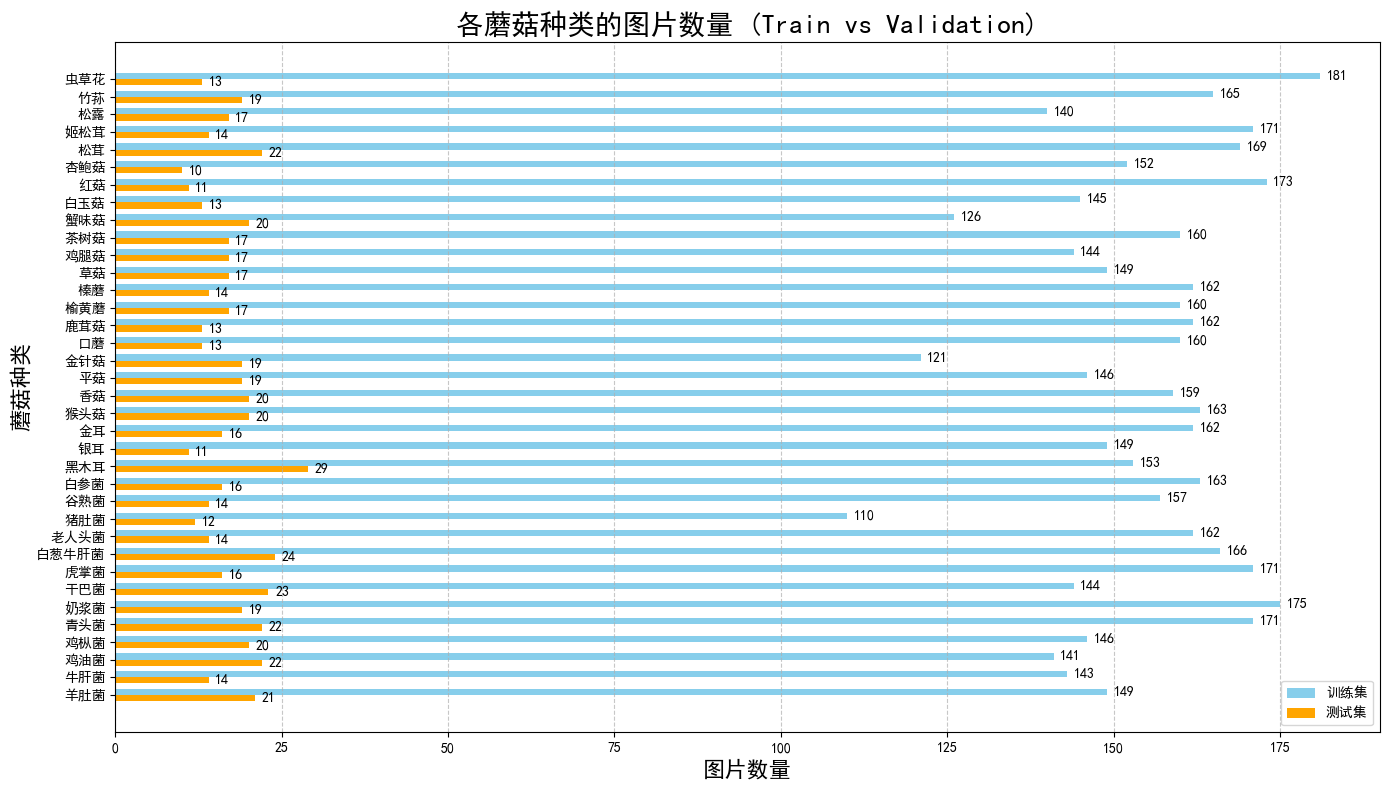

In [7]:
# 准备数据
categories_readable = list(categories.values())  # 使用中文名映射
train_counts = [train_category_counts[name] for name in categories_readable]
validation_counts = [validation_category_counts[name] for name in categories_readable]

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 设置柱子的位置
bar_width = 0.35
index = np.arange(len(categories_readable))

# 绘制训练集柱状图
bars_train = plt.barh(index + bar_width, train_counts, bar_width, label='训练集', color='skyblue')

# 绘制验证集柱状图
bars_validation = plt.barh(index, validation_counts, bar_width, label='测试集', color='orange')

# 添加数据标签
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, '%d' % int(width), ha='left', va='center')

add_labels(bars_train)
add_labels(bars_validation)

# 设置标题和标签
plt.title('各蘑菇种类的图片数量 (Train vs Validation)', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置Y轴刻度
plt.yticks(index + bar_width / 2, categories_readable)

# 显示网格
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 添加图例
plt.legend()

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

## 显示数据集中的图像样本

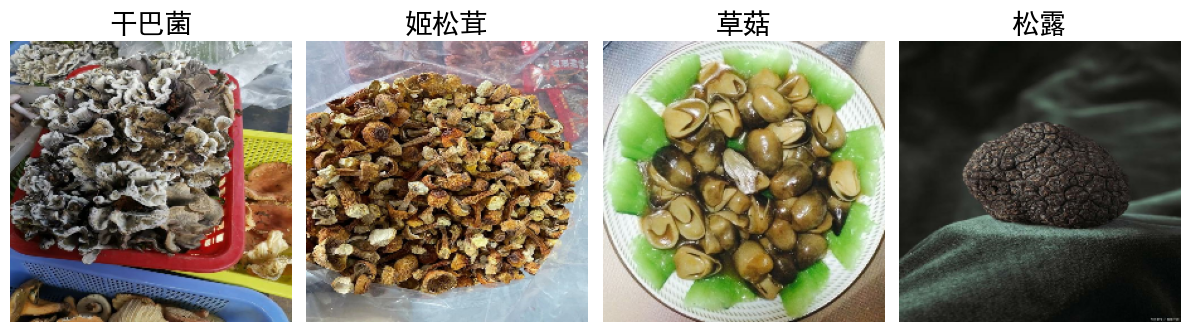

In [8]:
# 获取类别名称
class_names = train_dataset.class_names

# 设置要显示的图像数量
num_images_to_show = 4
images_to_display = []
labels_to_display = []

# 从数据集中获取随机选择的图像和标签
for images, labels in train_dataset.take(1):
    indices = np.random.choice(range(images.shape[0]), num_images_to_show, replace=False)
    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

# 创建图形并显示图像
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(categories[class_names[np.argmax(label.numpy())]], fontsize=20)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 数据增强

数据增强是一种常用的技术，用于通过变换现有数据来增加训练数据的多样性，从而提高模型的泛化能力。在图像处理中，常见的数据增强技术包括旋转、翻转、缩放、裁剪、亮度调整等。

## 定义数据增强层

In [9]:
# 定义数据增强的预处理层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 水平翻转
    tf.keras.layers.RandomRotation(0.2),       # 随机旋转最多20%
    tf.keras.layers.RandomZoom(0.2, 0.2),      # 随机缩放
    tf.keras.layers.RandomContrast(0.2),       # 随机对比度调整
    tf.keras.layers.RandomBrightness(0.2)      # 随机亮度调整
])

## 定义显示数据增强示例函数

In [10]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

## 获取随机批次

In [11]:
# 获取训练集中随机的一批次图片
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


## 显示数据增强示例

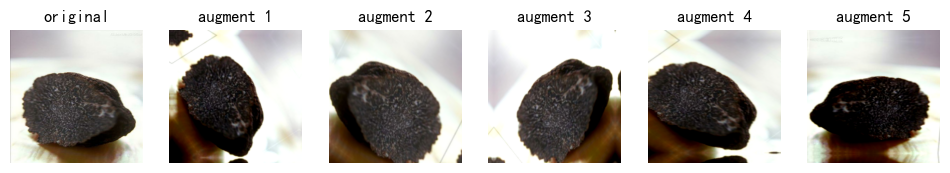

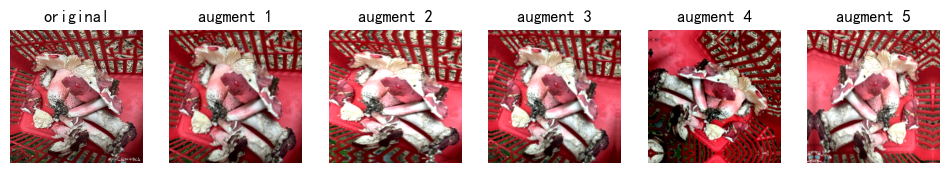

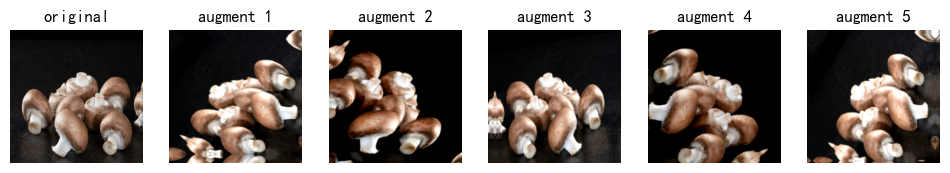

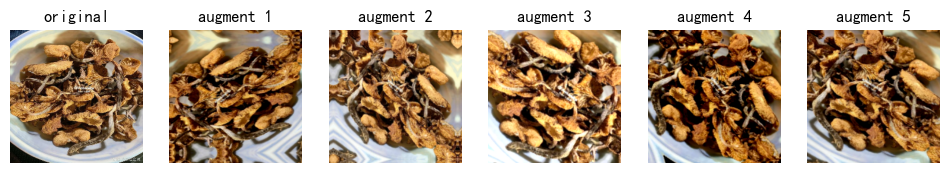

In [12]:
NUM_AUG = 5

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# MobileNetV1模型

In [13]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.mobilenet.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
MobileNet = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
MobileNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
MobileNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,500,516 (13.35 MB)

 Trainable params: 271,652 (1.04 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [14]:
# Train the model
MobileNet_history = MobileNet.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.0892 - loss: 3.5629 - val_accuracy: 0.2864 - val_loss: 2.7335
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.3437 - loss: 2.5421 - val_accuracy: 0.4223 - val_loss: 2.1303
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.4697 - loss: 2.0083 - val_accuracy: 0.4871 - val_loss: 1.8279
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.5388 - loss: 1.7124 - val_accuracy: 0.5324 - val_loss: 1.6897
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.5785 - loss: 1.5554 - val_accuracy: 0.5631 - val_loss: 1.5854
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.6097 - loss: 1.4273 - val_accuracy: 0.5744 - val_loss: 1.5344
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.6325 - loss: 1.3600 - val_accuracy: 0.5841 - val_loss: 1.4878
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.6458 - loss: 1.2840 -

In [15]:
def show_history(history):
  # 绘制训练过程中的损失和准确率曲线
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

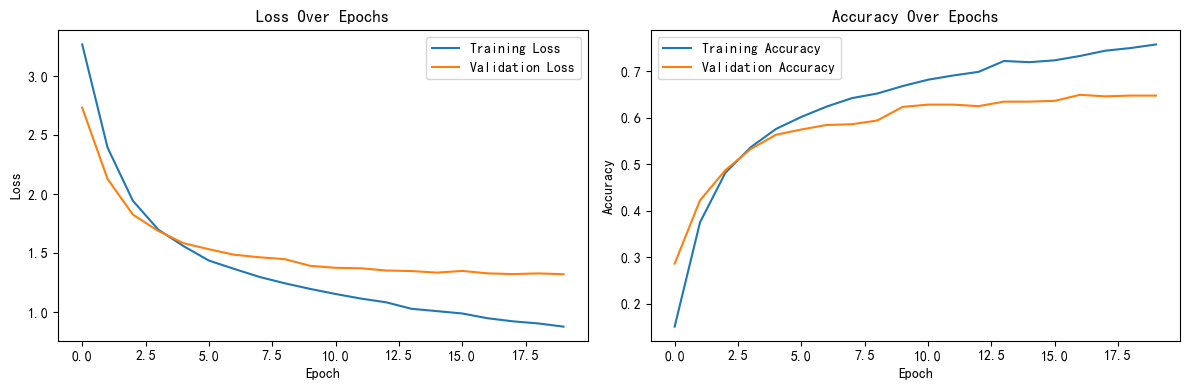

In [16]:
show_history(MobileNet_history)

# MobileNetV2模型

In [18]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
MobileNetV2 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
MobileNetV2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,595,172 (9.90 MB)

 Trainable params: 337,188 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# Train the model
MobileNetV2_history = MobileNetV2.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.1077 - loss: 3.4854 - val_accuracy: 0.3252 - val_loss: 2.6859
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.4112 - loss: 2.3924 - val_accuracy: 0.4579 - val_loss: 2.0621
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5312 - loss: 1.8318 - val_accuracy: 0.5065 - val_loss: 1.7924
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.5856 - loss: 1.5793 - val_accuracy: 0.5469 - val_loss: 1.6378
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.6218 - loss: 1.4183 - val_accuracy: 0.5647 - val_loss: 1.5584
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.6489 - loss: 1.3230 - val_accuracy: 0.5874 - val_loss: 1.5074
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.6601 - loss: 1.2664 - val_accuracy: 0.6019 - val_loss: 1.4722
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.6918 - loss: 1.1819 

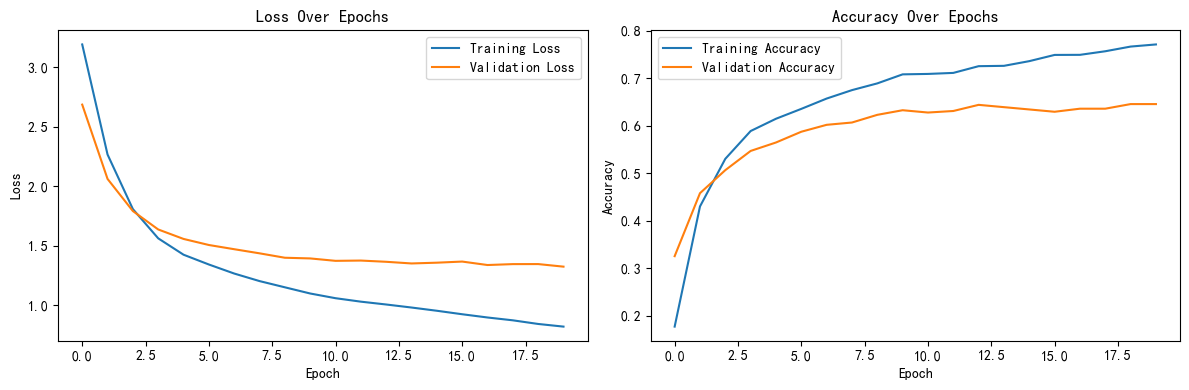

In [20]:
show_history(MobileNetV2_history)

# MobileNetV3Small

In [21]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
MobileNetV3Small = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
MobileNetV3Small.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
MobileNetV3Small.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,096,084 (4.18 MB)

 Trainable params: 156,964 (613.14 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [22]:
# Train the model
MobileNetV3Small_history = MobileNetV3Small.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.0608 - loss: 3.6566 - val_accuracy: 0.2314 - val_loss: 2.9711
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.2821 - loss: 2.8710 - val_accuracy: 0.3932 - val_loss: 2.3810
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.4195 - loss: 2.3312 - val_accuracy: 0.4757 - val_loss: 2.0250
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.4818 - loss: 2.0040 - val_accuracy: 0.5146 - val_loss: 1.8236
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.5212 - loss: 1.8242 - val_accuracy: 0.5421 - val_loss: 1.6893
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.5526 - loss: 1.6728 - val_accuracy: 0.5502 - val_loss: 1.5970
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.5801 - loss: 1.5833 - val_accuracy: 0.5583 - val_loss: 1.5400
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.5897 - loss: 1.5027 -

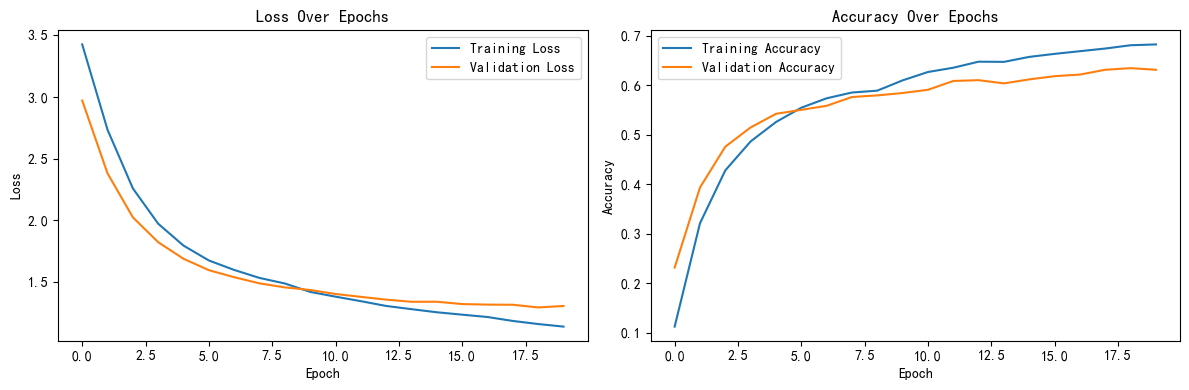

In [23]:
show_history(MobileNetV3Small_history)

# EfficientNet模型

In [26]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.efficientnet.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
EfficientNetB0 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
EfficientNetB0.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,386,759 (16.73 MB)

 Trainable params: 337,188 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [27]:
# Train the model
EfficientNetB0_history = EfficientNetB0.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.1154 - loss: 3.4467 - val_accuracy: 0.4045 - val_loss: 2.7477
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.4366 - loss: 2.5551 - val_accuracy: 0.5275 - val_loss: 2.0365
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5441 - loss: 1.9500 - val_accuracy: 0.5777 - val_loss: 1.7033
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.6081 - loss: 1.6285 - val_accuracy: 0.6117 - val_loss: 1.5314
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.6500 - loss: 1.4402 - val_accuracy: 0.6278 - val_loss: 1.4266
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.6552 - loss: 1.3314 - val_accuracy: 0.6472 - val_loss: 1.3536
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.6827 - loss: 1.2513 - val_accuracy: 0.6570 - val_loss: 1.3018
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.6994 - loss: 1.1876

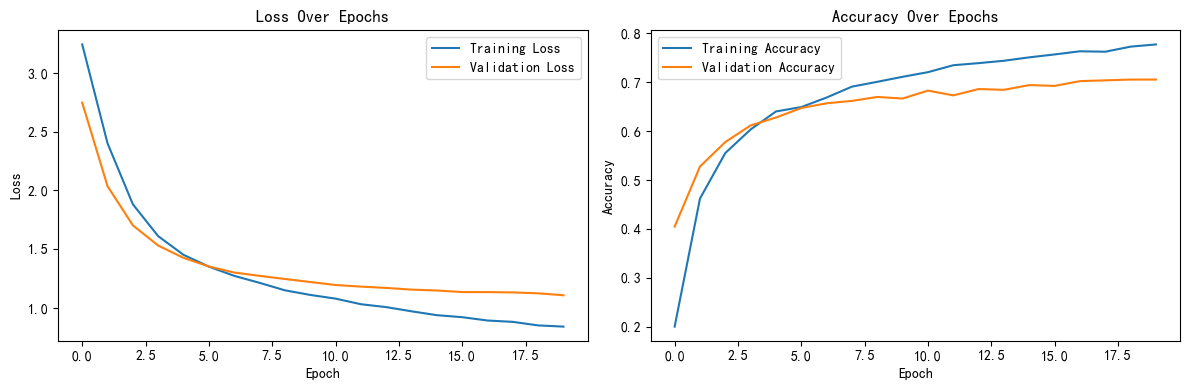

In [28]:
show_history(EfficientNetB0_history)

# EfficientNetV2S模型

In [29]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.EfficientNetV2S(
    input_shape=(224, 224, 3),
    include_top=False,
    include_preprocessing=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
EfficientNetV2S = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
EfficientNetV2S.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
EfficientNetV2S.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,668,548 (78.84 MB)

 Trainable params: 337,188 (1.29 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [30]:
# Train the model
EfficientNetV2S_history = EfficientNetV2S.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 233ms/step - accuracy: 0.0338 - loss: 69.5405 - val_accuracy: 0.0275 - val_loss: 33.1460
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - accuracy: 0.0322 - loss: 37.8745 - val_accuracy: 0.0437 - val_loss: 17.3223
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 180ms/step - accuracy: 0.0256 - loss: 18.6716 - val_accuracy: 0.0275 - val_loss: 7.3136
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.0271 - loss: 9.8338 - val_accuracy: 0.0210 - val_loss: 4.6870
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.0269 - loss: 6.4450 - val_accuracy: 0.0275 - val_loss: 4.0329
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.0355 - loss: 5.1681 - val_accuracy: 0.0291 - val_loss: 3.8426
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.0312 - loss: 4.6787 - val_accuracy: 0.0259 - val_loss: 3.7287
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step - accuracy: 0.0319 - lo

KeyboardInterrupt: 

In [ ]:
show_history(EfficientNetV2S_history)

# Convnext模型

In [ ]:
# 初始化基础模型
pre_trained_model = tf.keras.applications.ConvNeXtSmall(
    input_shape=(224, 224, 3),
    include_top=False,
    include_preprocessing=False,
    weights='imagenet'
)

# 冻结基础模型的权重
for layer in pre_trained_model.layers:
    layer.trainable = False

# 应用数据增强和预处理
x = data_augmentation(pre_trained_model.input)
x = tf.keras.applications.convnext.preprocess_input(x)

# 添加自定义顶层分类器
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# 构建最终模型
ConvNeXtSmall = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

# 编译模型
ConvNeXtSmall.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 查看模型结构
ConvNeXtSmall.summary()

In [ ]:
# Train the model
ConvNeXtSmall_history = ConvNeXtSmall.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset)


In [ ]:
show_history(ConvNeXtSmall_history)